In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from torch.autograd import Variable
train_x = Variable(torch.linspace(0, 1, 11))
train_y = Variable(torch.sin(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2)

In [3]:
from torch import nn, optim
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [6]:
class KissGPModel(gpytorch.GPModel):
    def __init__(self):
        super(KissGPModel, self).__init__(GaussianLikelihood())
        self.mean_module = ConstantMean()
        covar_module = RBFKernel()
        self.grid_covar_module = GridInterpolationKernel(covar_module, 50)
        self.register_parameter('log_noise', nn.Parameter(torch.Tensor([0])), bounds=(-5,5))
        self.register_parameter('log_lengthscale', nn.Parameter(torch.Tensor([0])), bounds=(-5, 5))

    def forward(self, x):
        mean_x = self.mean_module(x, constant=Variable(torch.Tensor([0])))
        covar_x = self.grid_covar_module(x, log_lengthscale=self.log_lengthscale)
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred, self.log_noise

prior_model = KissGPModel()

In [9]:
def plot_model_and_predictions(model, plot_train_data=True):
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    test_x = Variable(torch.linspace(0, 1, 51))
    observed_pred = model(test_x)

    def ax_plot(ax, rand_var, title):
        lower, upper = rand_var.confidence_region()
        if plot_train_data:
            ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
        ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
        ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_title(title)
    
    ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')
    
    return f

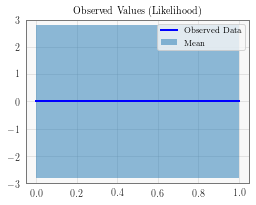

In [10]:
fig = plot_model_and_predictions(prior_model, plot_train_data=False)

In [11]:
from gpytorch.inference import Inference
infer = Inference(prior_model)
posterior_model = infer.run(train_x, train_y)

# Find optimal model hyperparameters
posterior_model.train()
optimizer = optim.Adam(posterior_model.parameters(), lr=0.1)
optimizer.n_iter = 0
for i in range(50):
    optimizer.zero_grad()
    output = posterior_model(train_x)
    loss = -posterior_model.marginal_log_likelihood(output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/20 - Loss: %.3f   log_lengthscale: %.3f   log_noise: %.3f' % (
        i + 1, loss.data[0],
        posterior_model.prior_model.log_lengthscale.data[0],
        posterior_model.prior_model.log_noise.data[0]
    ))
    optimizer.step()
    
# Set back to eval mode
posterior_model.eval()
None

/Users/gpleiss/Dropbox/workspace/gpytorch/gpytorch/kernels/rbf_kernel.py:41: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  grad.mul_(grad_output.transpose(0, 1))


Iter 1/20 - Loss: 12.720   log_lengthscale: 0.000   log_noise: 0.000
Iter 2/20 - Loss: 13.112   log_lengthscale: 0.100   log_noise: -0.100
Iter 3/20 - Loss: 12.647   log_lengthscale: 0.199   log_noise: -0.199
Iter 4/20 - Loss: 12.625   log_lengthscale: 0.273   log_noise: -0.298
Iter 5/20 - Loss: 12.093   log_lengthscale: 0.293   log_noise: -0.396
Iter 6/20 - Loss: 12.597   log_lengthscale: 0.342   log_noise: -0.494
Iter 7/20 - Loss: 11.230   log_lengthscale: 0.378   log_noise: -0.589
Iter 8/20 - Loss: 12.233   log_lengthscale: 0.418   log_noise: -0.684
Iter 9/20 - Loss: 12.913   log_lengthscale: 0.472   log_noise: -0.776
Iter 10/20 - Loss: 11.062   log_lengthscale: 0.497   log_noise: -0.863
Iter 11/20 - Loss: 11.893   log_lengthscale: 0.503   log_noise: -0.948
Iter 12/20 - Loss: 12.343   log_lengthscale: 0.498   log_noise: -1.027
Iter 13/20 - Loss: 11.815   log_lengthscale: 0.479   log_noise: -1.100
Iter 14/20 - Loss: 11.916   log_lengthscale: 0.459   log_noise: -1.166
Iter 15/20 - Los

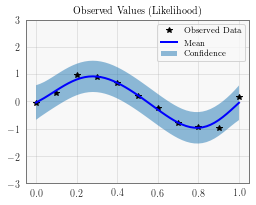

In [13]:
fig = plot_model_and_predictions(posterior_model)